# "Getting to know DICOMS"
> "Taking a deeper look at how to view and manipulate DICOM images"
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [medical_imaging, dicom, fastai]
- image: images/gdicom.PNG

#### DICOM Datasets

Here is a list of 3 DICOM datasets that you can play around with. Each of these 3 datasets have different attributes and shows how there can be a vast difference in what is contained in different DICOM datasets.

- the `SIIM_SMALL` dataset ((250 DICOM files, ~30MB) is conveniently provided in the `fastai` library but is limited in some of its attributes for example it does not have RescaleIntercept or RescaleSlope and its pixel range is limited in the range of 0 and 255


- Kaggle has an easily accessible (437MB) [CT medical image dataset](https://www.kaggle.com/kmader/siim-medical-images) from the cancer imaging archive.  The dataset consists of 100 images (512px by 512px) with pixel ranges from -2000 to +2000


- The [Thyroid Segmentation in Ultrasonography Dataset](https://opencas.webarchiv.kit.edu/?q=node/29) provides low quality (ranging from 253px by 253px) DICOM images where each DICOM image has multiple frames (average of 1000)

In [1]:
#Load the dependancies
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.medical.imaging import *

import pydicom
import seaborn as sns
matplotlib.rcParams['image.cmap'] = 'bone'
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#### Loading DICOMs which have 1 frame per file

The `SIIM_SMALL` dataset is a DICOM dataset where each DICOM file has a `pixel_array` that contains 1 image. In this case the `show` function within `fastai.medical.imaging` conveniently displays the image

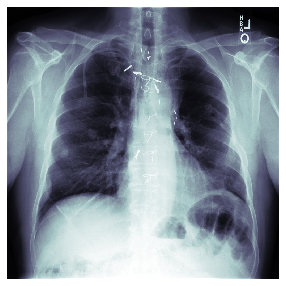

In [2]:
source = untar_data(URLs.SIIM_SMALL)
items = get_dicom_files(source)
patient1 = dcmread(items[0])
patient1.show()

Loading an image from the `CT medical image dataset` which also contains 1 frame per `DICOM` file.  This image is a slice of a CT scan looking at the lungs with the heart in the middle.

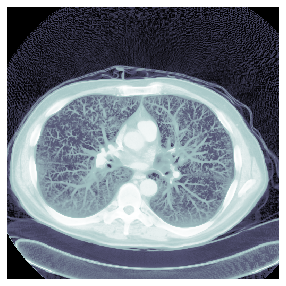

In [3]:
csource = Path('C:/PillView/NIH/data/dicoms')
citems = get_dicom_files(csource)
patient2 = dcmread(citems[0])
patient2.show()

However what if a `DICOM` dataset has multiple frames per `DICOM` file

#### Loading DICOMs which have multiple frames per file

The [Thyroid Segmentation in Ultrasonography Dataset](https://opencas.webarchiv.kit.edu/?q=node/29) is a dataset where each `DICOM`file has multiple frames per file.  Using the same format as above to view an image:

In [4]:
tsource = Path('C:/PillView/NIH/data/thyroid')
titems = get_dicom_files(tsource)
patient3 = dcmread(titems[0])
#patient3.show()

This will result in a `TypeError` because the current `show` function does not have a means of displaying files with multiple frames 

![type error](my_icons/typeerror.PNG)

Customizing the `show` function now checks to see if the file contains more than 1 frame and then displays the image accordingly.  You can also choose how many `frames` to view (the default is 1).  It was also noted that the `show_images` function does not accept `colormaps` and hence that function also had to be slightly modified

In [5]:
#updating to handle colormaps
@delegates(subplots)
def show_images(ims, nrows=1, ncols=None, titles=None, cmap=None, **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    if ncols is None: ncols = int(math.ceil(len(ims)/nrows))
    if titles is None: titles = [None]*len(ims)
    axs = subplots(nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip(ims, titles, axs): show_image(im, ax=ax, title=t, cmap=cmap)

In [6]:
#updating to handle multiple frames
@patch
@delegates(show_image, show_images)
def show(self:DcmDataset, frames=1, scale=True, cmap=plt.cm.bone, min_px=-1100, max_px=None, **kwargs):
    px = (self.windowed(*scale) if isinstance(scale,tuple)
          else self.hist_scaled(min_px=min_px,max_px=max_px,brks=scale) if isinstance(scale,(ndarray,Tensor))
          else self.hist_scaled(min_px=min_px,max_px=max_px) if scale
          else self.scaled_px)
    if px.ndim > 2: 
        gh=[]
        p = px.shape; print(f'{p[0]} frames per file')
        for i in range(frames): u = px[i]; gh.append(u)
        show_images(gh, cmap=cmap, **kwargs)    
    else: 
        print('1 frame per file')
        show_image(px, cmap=cmap, **kwargs)

932 frames per file


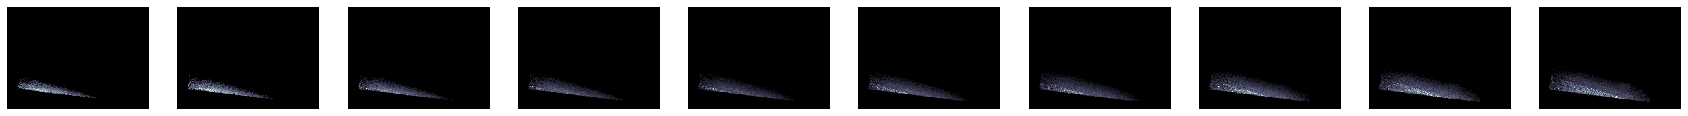

In [7]:
patient3.show(10)

The images now display the number of frames specified as well as how many frames there are in each file. It also now allows a `cmap` to be passed in.

932 frames per file


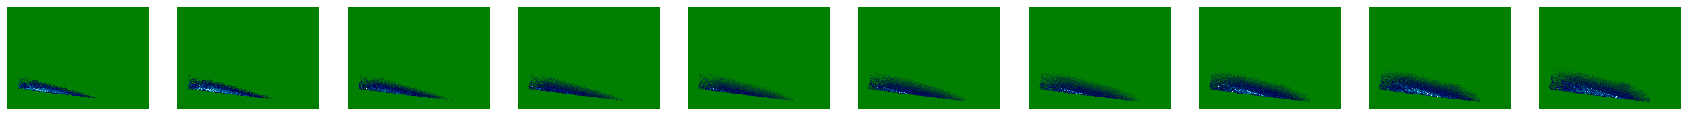

In [8]:
patient3.show(10, cmap=plt.cm.ocean)

This function also works when each `DICOM` file only has 1 frame

1 frame per file


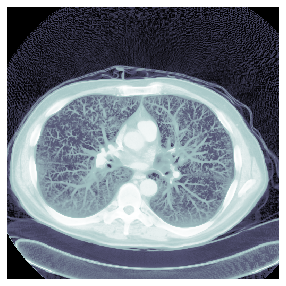

In [9]:
patient2.show()

##### Saving files from multiple frames

The `Thyroid segmentation` dataset is broken down into 2 folders each containing 16 `.dcm` files each.  It would be good to know what the total number of frames are within the dataset.

For this we use a custom function to get the total number of frames in the dataset and how many frames there are in each file

In [10]:
def get_num_frames(source):
    """Get the number of frames in each DICOM"""
    """Some DICOMs have multiple frames and this function helps to find the total number of frames in a DICOM dataset """
    frame_list = []
    h = get_dicom_files(source)
    for i, path in enumerate(h):
        test_im = h[i]
        j = dcmread(test_im) 
        try: 
            v = int(j.NumberOfFrames)
        except: 
            v=1
        frame_list.append(v)
        sl = sum(frame_list); ll = L(frame_list)
    return sl, ll

In [11]:
get_num_frames(tsource)

(31304, (#33) [932,942,1058,1120,958,1064,1134,1060,928,892...])

In this case there are a total of `31304` frames within the dataset with each file having between `800` to `1100` frames.  To view a range of frames:

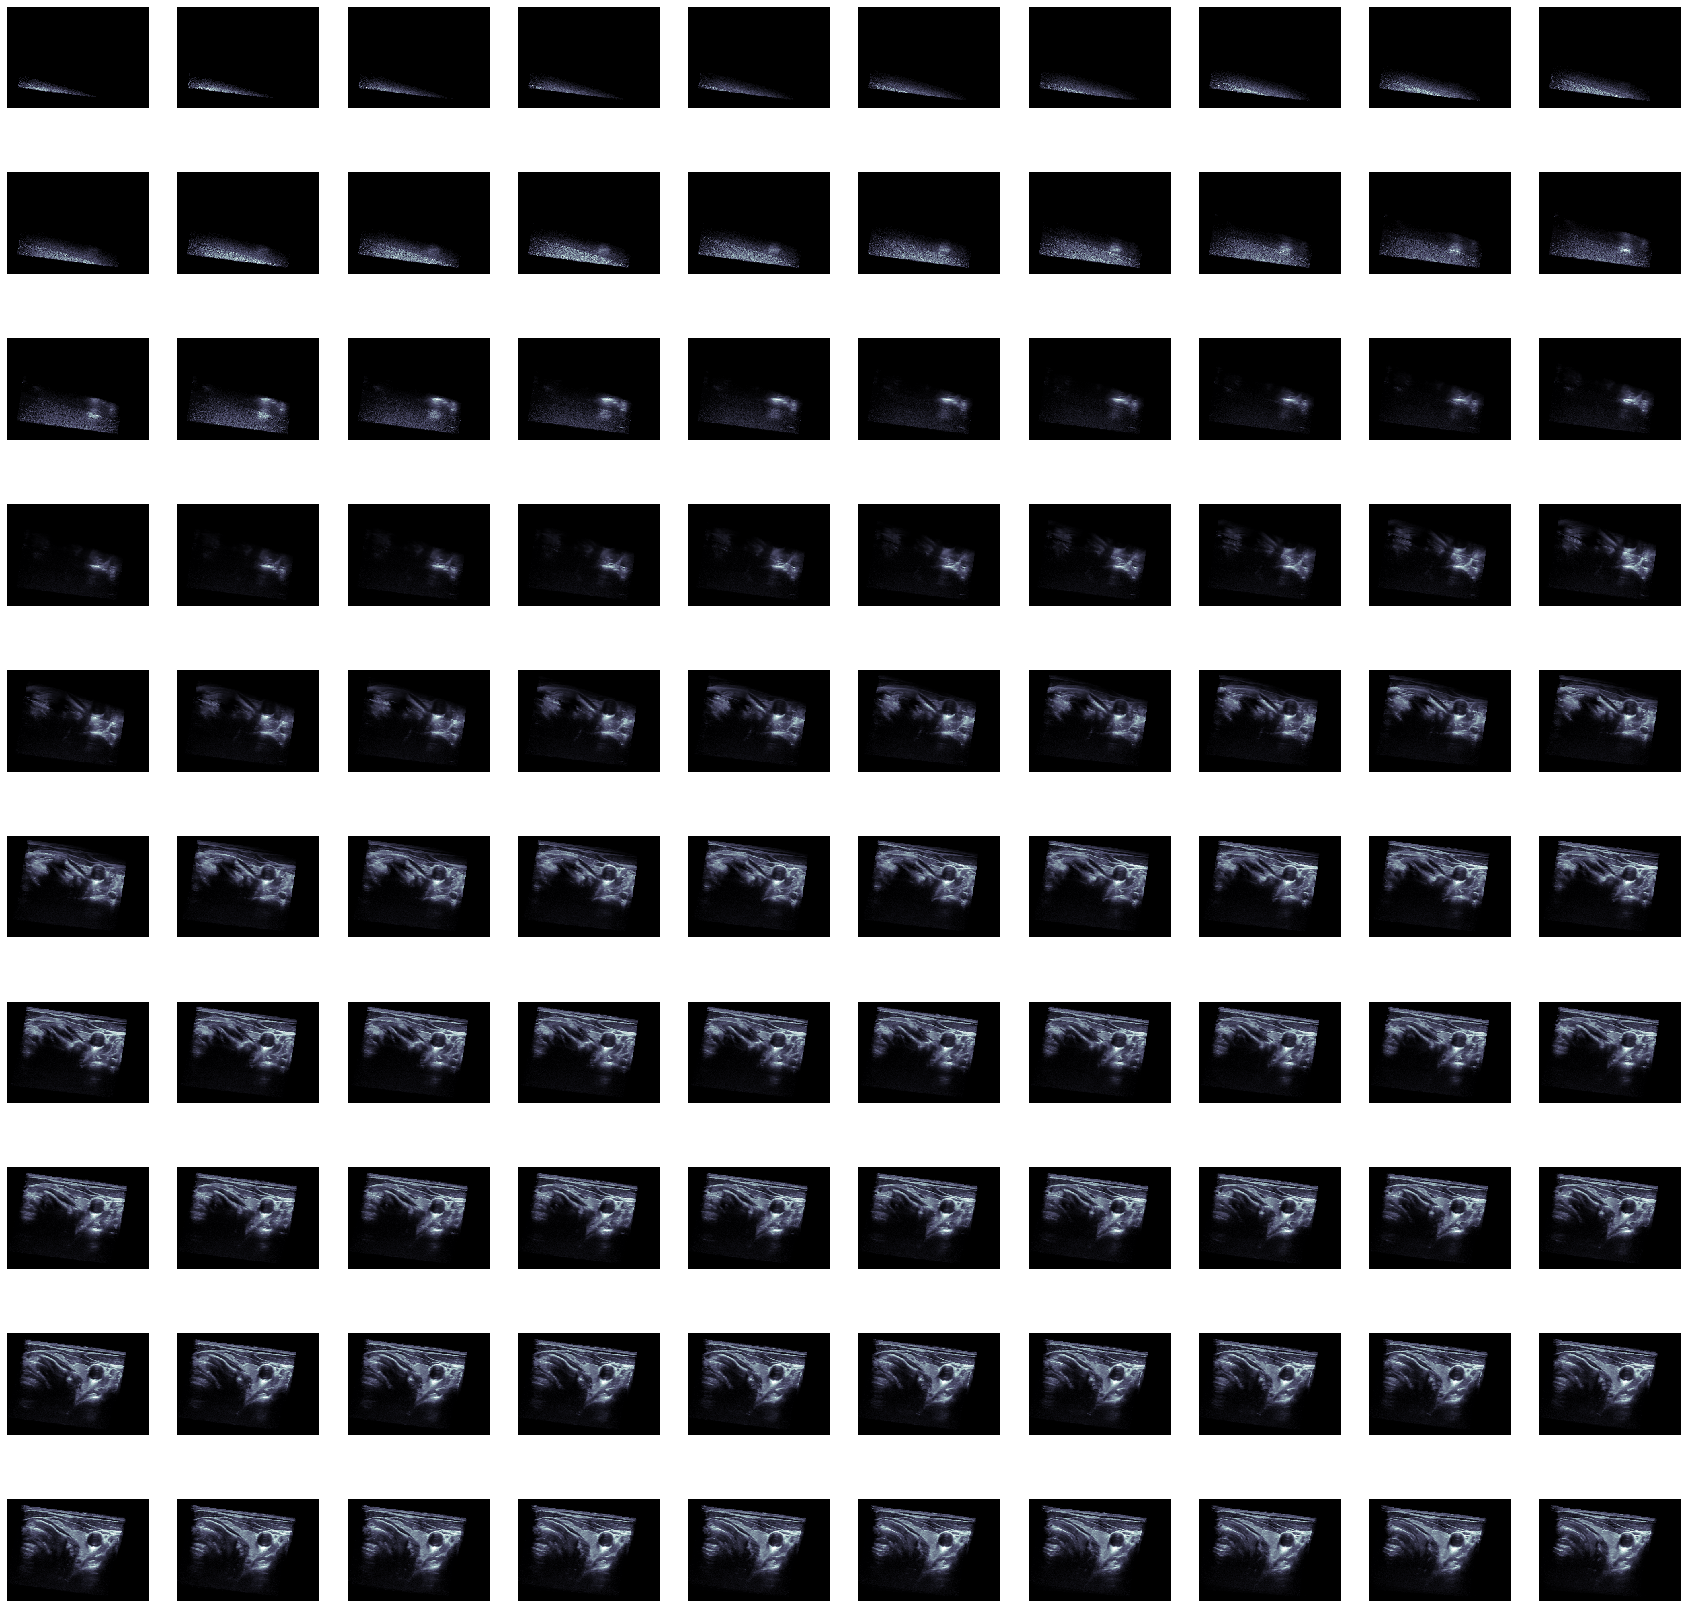

In [12]:
gh = []
for i in range(0,100):
    u = patient3.pixel_array[i,:,:]
    gh.append(u)
show_images(gh, nrows=10, ncols=10)

To save the frames into `.jpg` format you can use this function to extract frames from 1 file specifying the input `source` and the output

In [13]:
def get_frames(source, save_path):
    """extract frames from DICOM file and save into specified location"""
    h = get_dicom_files(source)
    test_im = h[0]
    j = dcmread(test_im)
    try:
        frame = int(j.NumberOfFrames)
        print(f'saving files in {save_path}')
    except:
        frame = 0
        print('file has no frames')
    for i in range(frame):
        u = j.pixel_array[i,:,:]
        im = Image.fromarray(u)
        im.save(f'{save_path}/image_{i}.jpg')
    return f'Number of frames saved: {frame}'

In [14]:
get_frames(tsource, tsource/'Test')

saving files in C:\PillView\NIH\data\thyroid\Test


'Number of frames saved: 932'

Another fastai function `from_dicoms` conveniently converts all the DICOM `head` attributes into a useable dataframe

In [15]:
t_df = pd.DataFrame.from_dicoms(titems)

Once converted you can now easily view various attributes about the dataset

In [16]:
#Plot 3 comparisons
def plot_comparison(df, feature, feature1, feature2):
    "Plot 3 comparisons from a dataframe"
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (16, 4))
    s1 = sns.countplot(df[feature], ax=ax1)
    s1.set_title(feature)
    s2 = sns.countplot(df[feature1], ax=ax2)
    s2.set_title(feature1)
    s3 = sns.countplot(df[feature2], ax=ax3)
    s3.set_title(feature2)
    plt.show()

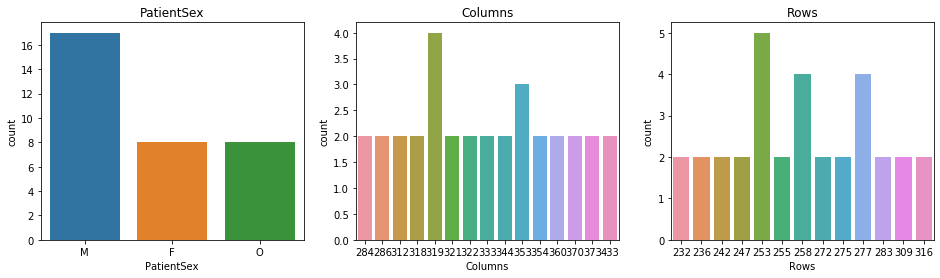

In [17]:
plot_comparison(t_df, 'PatientSex', 'Columns', 'Rows')

#### Viewing DICOM `tag` values

To view the `tag` values within the header you can use the `dir()` function

In [18]:
patient3.dir()

['AccessionNumber',
 'AcquisitionContextSequence',
 'AcquisitionDateTime',
 'AcquisitionDuration',
 'AcquisitionTimeSynchronized',
 'AnatomicRegionSequence',
 'ApexPosition',
 'BitsAllocated',
 'BitsStored',
 'BoneThermalIndex',
 'BurnedInAnnotation',
 'Columns',
 'ContentDate',
 'ContentTime',
 'CranialThermalIndex',
 'DepthOfScanField',
 'DepthsOfFocus',
 'DeviceSerialNumber',
 'DimensionIndexSequence',
 'DimensionOrganizationSequence',
 'DimensionOrganizationType',
 'FrameOfReferenceUID',
 'HighBit',
 'ImageComments',
 'ImageOrientationPatient',
 'ImagePositionPatient',
 'ImageType',
 'InstanceNumber',
 'InstitutionName',
 'InstitutionalDepartmentName',
 'LargestImagePixelValue',
 'LossyImageCompression',
 'Manufacturer',
 'ManufacturerModelName',
 'MechanicalIndex',
 'Modality',
 'NumberOfFrames',
 'OperatorsName',
 'PatientBirthDate',
 'PatientBirthTime',
 'PatientID',
 'PatientName',
 'PatientOrientation',
 'PatientSex',
 'PerFrameFunctionalGroupsSequence',
 'PhotometricInterpret

Its worth pointing out that there may be additional information (however not always the case) where there may be a `tag` for `ImageComments`.  This `tag` may contain information that may be useful in the modelling.  In this case not really useful information except that MeVisLab was used to probably generate the image

In [19]:
patient3.ImageComments

'MeVisLab'

#### Understanding Tissue Densities

There are a couple of downsides to the `SIMM_SLIM` dataset because it does not have a number of attributes including `RescaleIntercept` and `RescaleSlope` and its pixel distribution is limited to between `0` and `255` pixels.  In reality `DICOM` images have a far more wide-spread range of pixel values.

By using the [CT medical image dataset](https://www.kaggle.com/kmader/siim-medical-images) we can now play around with other useful `fastai.medical.imaging` functionality.  

`patient2` is an image from this dataset

In [20]:
tensor_dicom = pixels(patient2) #convert into tensor

print(f'RescaleIntercept: {patient2.RescaleIntercept:1f}\nRescaleSlope: {patient2.RescaleSlope:1f}\nMax pixel: '
      f'{tensor_dicom.max()}\nMin pixel: {tensor_dicom.min()}\nShape: {tensor_dicom.shape}')

RescaleIntercept: -1024.000000
RescaleSlope: 1.000000
Max pixel: 1918.0
Min pixel: 0.0
Shape: torch.Size([512, 512])


In this image the `RescaleIntercept` is `-1024`, the `RescaleSlope` is `1`, the `max` and `min` pixels are `1918` and `0` respectively and the  image size is `512` by `512`

Plotting a histogram of pixel intensities you can see where the bulk of pixels are located

(array([1.73881e+05, 1.82440e+04, 4.70700e+03, 3.24000e+03, 1.53940e+04,
        3.50250e+04, 7.98600e+03, 2.62500e+03, 8.99000e+02, 1.43000e+02]),
 array([   0. ,  191.8,  383.6,  575.4,  767.2,  959. , 1150.8, 1342.6,
        1534.4, 1726.2, 1918. ], dtype=float32),
 <a list of 10 Patch objects>)

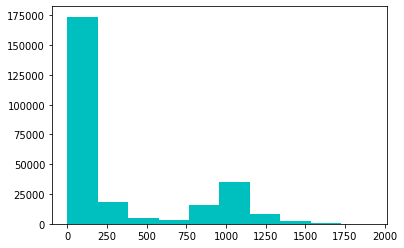

In [52]:
plt.hist(tensor_dicom.flatten(), color='c')

The histogram shows that the minimal pixel value is `0` and the maximum pixel value is `1918`.  The histogram is predominantly bi-modal with the majority of pixels between the `0` and `100` pixels and between `750` and `1100` pixels.

This image has a `RescaleIntercept` of `-1024` and a `RescaleSlope` of `1`.  These two values allows for transforming pixel values into [Hounsfield Units(HU)](https://en.wikipedia.org/wiki/Hounsfield_scale).  Densities of different tissues on CT scans are measured in HUs

Most CT scans range from `-1000`HUs to `+1000`HUs where water is `0`HUs, air is `-1000`HUs and the denser the tissues the higher the HU value.  Metals have a much higher HU range `+2000`HUs so for medical imaging a range of `-1000` to `+1000`HUs is suitable

The pixel values above do not correctly correspond to tissue densities.  For example most of the pixels are between pixel values `0` and `100` which correspond to water but this image is predominantly showing the lungs which are filled with air.  Air on the Hounsfield scale is `-1000` HUs.

This is where `RescaleIntercept` and `RescaleSlope` are important.  Fastai provides a convenient way `scaled_px` to rescale the pixels with respect to `RescaleIntercept` and `RescaleSlope`.

**rescaled pixel = pixel * RescaleSlope + RescaleIntercept**

(array([1.73881e+05, 1.82440e+04, 4.70700e+03, 3.24000e+03, 1.53940e+04,
        3.50250e+04, 7.98600e+03, 2.62500e+03, 8.99000e+02, 1.43000e+02]),
 array([-1024. ,  -832.2,  -640.4,  -448.6,  -256.8,   -65. ,   126.8,
          318.6,   510.4,   702.2,   894. ], dtype=float32),
 <a list of 10 Patch objects>)

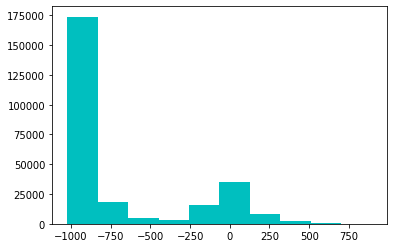

In [53]:
tensor_dicom_scaled = scaled_px(patient2) #convert into tensor taking RescaleIntercept and RescaleSlope into consideration
plt.hist(tensor_dicom_scaled.flatten(), color='c')

In [23]:
print(f'Max pixel: {tensor_dicom_scaled.max()}\nMin pixel: {tensor_dicom_scaled.min()}')

Max pixel: 894.0
Min pixel: -1024.0


After re-scaling the maximum pixel value is `894` and the minimum value is `-1024` and we can now correctly see what parts of the image correspond to what parts of the body based on the Hounsfield scale.

Looking at the top end of the histogram what does the image look like with values over 300 HUs?

The `show` function has the capability of specifying `max` and `min` values

1 frame per file


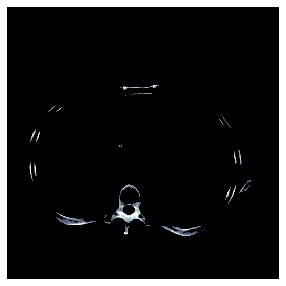

In [24]:
patient2.show(max_px=894, min_px=300, figsize=(5,5))

HU values above `+300` typically will show the bone stuctures within the image

1 frame per file


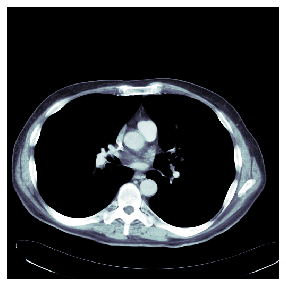

In [25]:
patient2.show(max_px=250, min_px=-250, figsize=(5,5))

Within this range you can now see the aorta and the parts of the heart(image middle) as well as muscle and fat.

1 frame per file


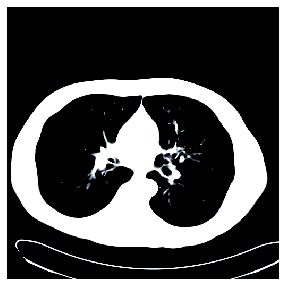

In [26]:
patient2.show(max_px=-250, min_px=-600, figsize=(5,5))

In this range you just make out outlines.  The histogram does show that within this range there are not many pixels

1 frame per file


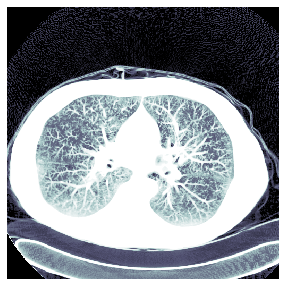

In [27]:
patient2.show(max_px=-600, min_px=-1000, figsize=(5,5))

Within this range you can clearly see the bronchi within the lungs

1 frame per file


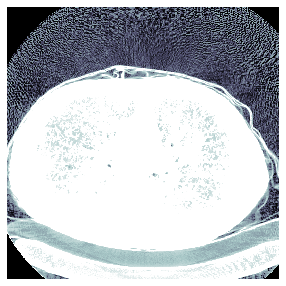

In [28]:
patient2.show(max_px=-900, min_px=-1024, figsize=(5,5))

At this range you can now also clearly see the curve of the scanner.

The `show` function by default has a `max_px` value of `None` and a `min_px` value of `-1100`

1 frame per file


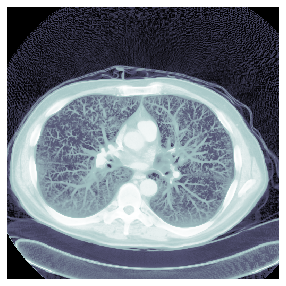

In [29]:
patient2.show(max_px=None, min_px=-1100, figsize=(5,5))

Image re-scaling as done above is really for the benefit of humans.  Computer screens can display about 256 shades of grey and the human eye is only capable of detecting about a 6% change in greyscale ([ref](https://www.youtube.com/watch?v=KZld-5W99cI)) meaning the human eye can only detect about 17 different shades of grey.

DICOM images may have a wide range from `-1000` to `+1000` and for humans to be able to see relevant structures within the image a process of `windowing` is utilized.  Fastai provides various `dicom_windows` so that only specific HU values are displayed on the screen.  More about windowing can be found [here](https://asvcode.github.io/Blogs/medical_imaging/dicom/fastai/2020/04/28/Medical-Imaging-Part1.html#%3E%3E-Side-Note:-Windowing)

#### Bins

Where `windowing` is for the benefit of the human, computers produce better results from training when the data has a uniform distribution as mentioned in an article by Jeremy [don't see like a radiologist](https://www.kaggle.com/jhoward/don-t-see-like-a-radiologist-fastai/data)

Looking back at the pixel distribution we can see that the image does not have a uniform distribution

(array([1.73881e+05, 1.82440e+04, 4.70700e+03, 3.24000e+03, 1.53940e+04,
        3.50250e+04, 7.98600e+03, 2.62500e+03, 8.99000e+02, 1.43000e+02]),
 array([-1024. ,  -832.2,  -640.4,  -448.6,  -256.8,   -65. ,   126.8,
          318.6,   510.4,   702.2,   894. ], dtype=float32),
 <a list of 10 Patch objects>)

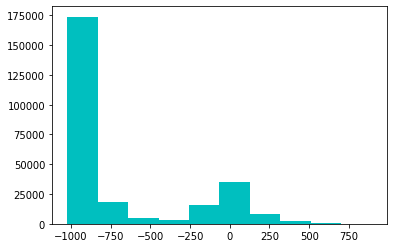

In [54]:
plt.hist(tensor_dicom_scaled.flatten(), color='c')

fastai has a function `freqhist_hist` that splits the range of pixel values into groups depending on what value you set for `n_bins`, such that each group has around the same number of pixels.

For example if you set `n_bins` to 1, the pixel values are split into 2 distinct pixel bins

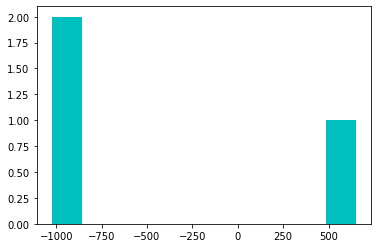

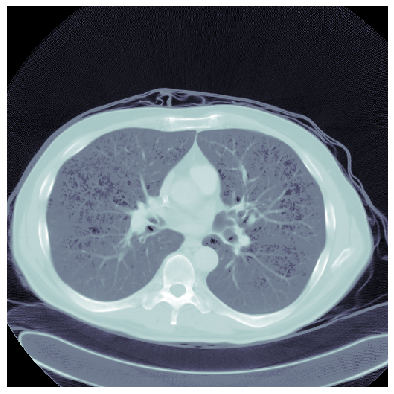

In [46]:
ten_freq = tensor_dicom_scaled.freqhist_bins(n_bins=1)
fh = patient2.hist_scaled(ten_freq)
plt.hist(ten_freq.flatten(), color='c'); show_image(fh, figsize=(7,7))

In this case you see the 2 polar sides of the image at `-1000`HUs you see the air portions and at `500`HUs you see the bone structures clearly but the distribution is still not fully acceptable for the machine learning model.

with `n_bins` at `100`(this is the default number used by `show`)

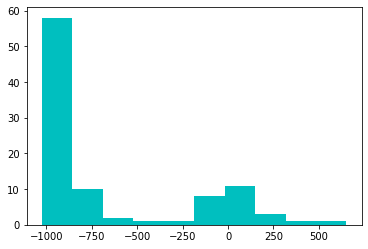

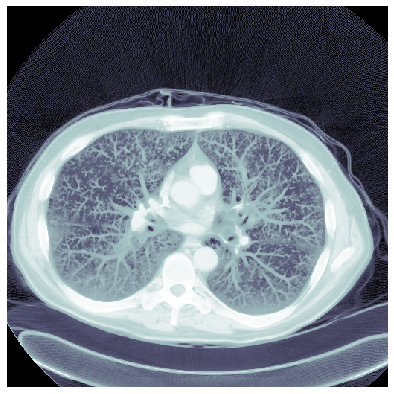

In [47]:
ten_freq2 = tensor_dicom_scaled.freqhist_bins(n_bins=100)
fh2 = patient2.hist_scaled(ten_freq2)
plt.hist(ten_freq2.flatten(), color='c'); show_image(fh2, figsize=(7,7))

with `n_bins` at `100000` the pixels are showing a more uniform distribution

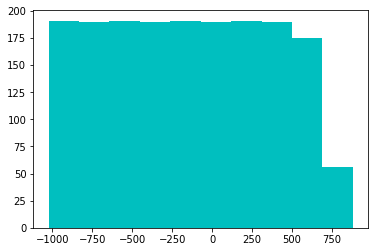

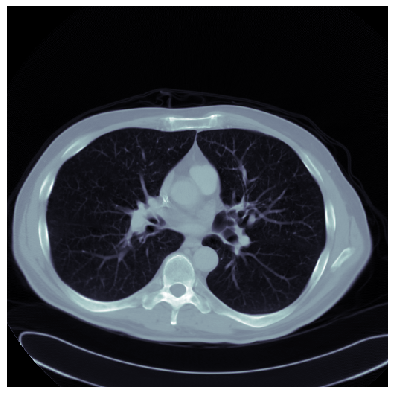

In [51]:
ten_freq3 = tensor_dicom_scaled.freqhist_bins(n_bins=100000)
fh3 = patient2.hist_scaled(ten_freq3)
plt.hist(ten_freq3.flatten(), color='c'); show_image(fh3, figsize=(7,7))

What effect does this have on training outcomes.  That will be the topic of the next blog

### fin